In [1]:
#hopper.ipynb
#
#by Joe Hahn
#jmh.datasciences@gmail.com
#5 February 2018
#
#hopper uses Q-learning to teach a neural net AI to...

In [2]:
#game settings
max_moves = 1000
N_neurons = 128
rn_seed = 13

In [3]:
#import the hopper game
from hopper import *

In [4]:
#initialize system
N_moves = 1
environment = initialize_environment(rn_seed, max_moves)
state = initialize_state(environment)
reward = get_reward(state)
separation, angle = get_separation(state)
game_state = get_game_state(N_moves, environment)
print 'environment = ', environment
print 'state = ', state
print 'reward = ', reward
print 'separation = ', separation
print 'angle = ', angle
print 'game_state = ', game_state

environment =  {'max_moves': 1000, 'rn_seed': 13, 'acts': ['slow-left', 'slow-right', 'fast-left', 'fast-right'], 'actions': [0, 1, 2, 3]}
state =  {'cat_run_direction_angle': -1.0109907737988257, 'bug_direction_angle': -1.0109907737988257, 'bug_distance': 4.9472370536058889, 'bug': array([ 0.,  0.]), 'cat': array([-2.62708895,  4.19208279])}
reward =  0.201762407005
separation =  4.94723705361
angle =  -1.0109907738
game_state =  running


In [5]:
#play one game
strategy = 'slow'
memories = play_game(environment, strategy)
cat, bug, rewards, bug_distances, bug_direction_angles, cat_direction_angles, turns = memories2arrays(memories)
cumulative_rewards = rewards.cumsum()
cumulative_bug_distances = bug_distances.cumsum()

In [6]:
#import plotting libraries
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5, font='DejaVu Sans')

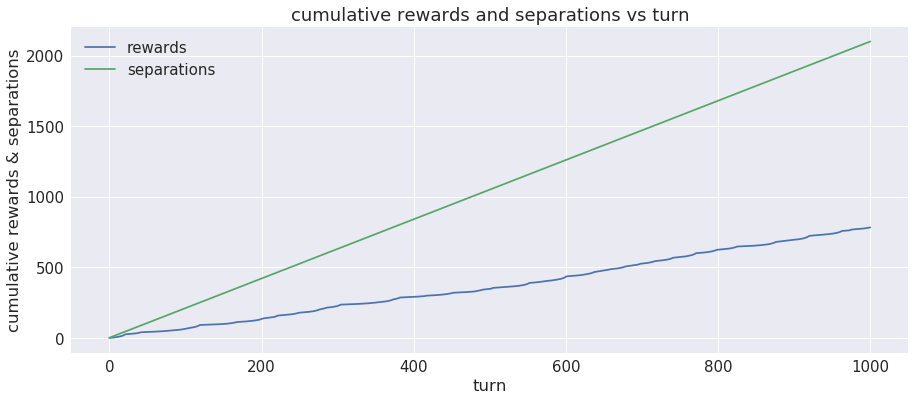

In [7]:
#plot cumulative rewards and separations vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = cumulative_rewards
ax.plot(xp, yp, label='rewards')
yp = cumulative_bug_distances
ax.plot(xp, yp, label='separations')
ax.set_title('cumulative rewards and separations vs turn')
ax.set_ylabel('cumulative rewards & separations')
ax.set_xlabel('turn')
plt.legend()
plt.savefig('figs/rewards.png')

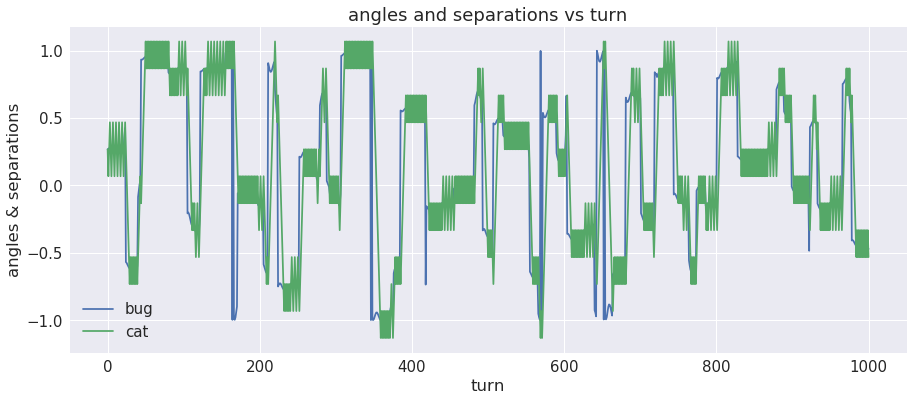

In [8]:
#plot bug and cat direction angles vs turn
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = turns
yp = bug_direction_angles/np.pi
ax.plot(xp, yp, label='bug')
yp = cat_direction_angles/np.pi
ax.plot(xp, yp, label='cat')
ax.set_title('angles and separations vs turn')
ax.set_ylabel('angles & separations')
ax.set_xlabel('turn')
plt.legend()
plt.savefig('figs/angles.png')

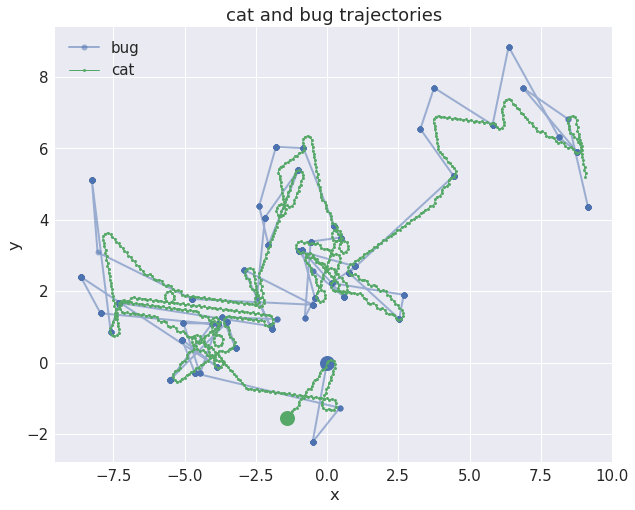

In [9]:
#plot separations and rewards vs turn
fig, ax = plt.subplots(1,1, figsize=(10, 8))
xp = bug[:,0]
yp1 = bug[:,1]
colors=sns.color_palette()
ax.plot(xp, yp1, marker='o', markersize=6, linewidth=2, alpha=0.5, color=colors[0], label='bug')
ax.plot(xp[0], yp1[0], marker='o', markersize=15, color=colors[0])
xp = cat[:,0]
yp2 = cat[:,1]
ax.plot(xp, yp2, marker='o', markersize=3, linestyle='-', linewidth=1, color=colors[1], label='cat')
ax.plot(xp[0], yp2[0], marker='o', markersize=15, color=colors[1])
ax.set_title('cat and bug trajectories')
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend()
plt.savefig('figs/xy.png')

In [10]:
#build neural network model
state_vector = state2vector(state)
N_inputs = state_vector.shape[1]
N_outputs = len(environment['actions'])
N_neurons = 128
model = build_model(N_inputs, N_neurons, N_outputs)
print model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
_________________________________________________________________
activation_3 (Activation)    (None, 4)                 0         
Total params: 17,540
Trainable params: 17,540
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
#Use Q-learning to train neural network to walk agent A towards goal G...for details see
#the train() function in grid_walker.py...about two minutes to execute.
#cat_strategy = 'ai'
N_training_games = 50
gamma = 0.85                           #discount for future rewards
batch_size = len(memories)/15          #number of memories to use when fitting the model
debug = False
print 'training model...'
trained_model = train(environment, model, N_training_games, gamma, memories, batch_size, debug=debug)
print 'training done.'

training model...
training done.
